In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, GlobalAveragePooling2D
import seaborn as sb
import deepdish as dd
from datahandling import read_wbt, load_wbt, get_clean_wingbeats_multiple_runs
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras import backend as K
tf.enable_eager_execution() 

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d2'
nb_classes = 2
# clean = True

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/pyt

### LOADING DATA

In [3]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [4]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [5]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [6]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    13644
0     9105
dtype: int64

val: 
1    4566
0    3017
dtype: int64

test: 
1    14637
0    12126
dtype: int64


### LOADING MODEL

In [7]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_loss')
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes, extra_dense_layer=False)
model = modelconf.config

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
model.load_weights(f"{TEMP_DATADIR}/Flies_rawflt_conv1d2_custom.h5")
# model.summary()

############ INPUT SHAPE:(5000, 1)


In [8]:
y_scores = model.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting, binary_labels=True),
                         steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                         verbose=1)

837/837 [==============================] - 93s 111ms/step


In [9]:
df = pd.DataFrame({"x": X_test, "y": y_test, "score0":y_scores[:,0], "score1":y_scores[:,1]})
df['pred'] = np.argmax(y_scores, axis=1)
df["right"] = df.y == df.pred

In [10]:
y_testcat = to_categorical(y_test)

cce = CategoricalCrossentropy(reduction="none")

loss = cce(K.variable(y_testcat), K.variable(y_scores))
df['loss'] = pd.Series(loss.numpy()).round(6)

# How many intermediates do we have
#### Defining the range for intermediates (uncertain points) based on a softmax output range

644 within given range
52.48%% correct for the uncertain data points (644 total), average loss: 0.6961
94.03%% correct for certain data points (26119 total), average loss: 0.2472
94.15%% correct for a sample of certain data points (650 total), average loss: 0.2263
93.03%% correct for all data points (26763 total), average loss: 0.2580


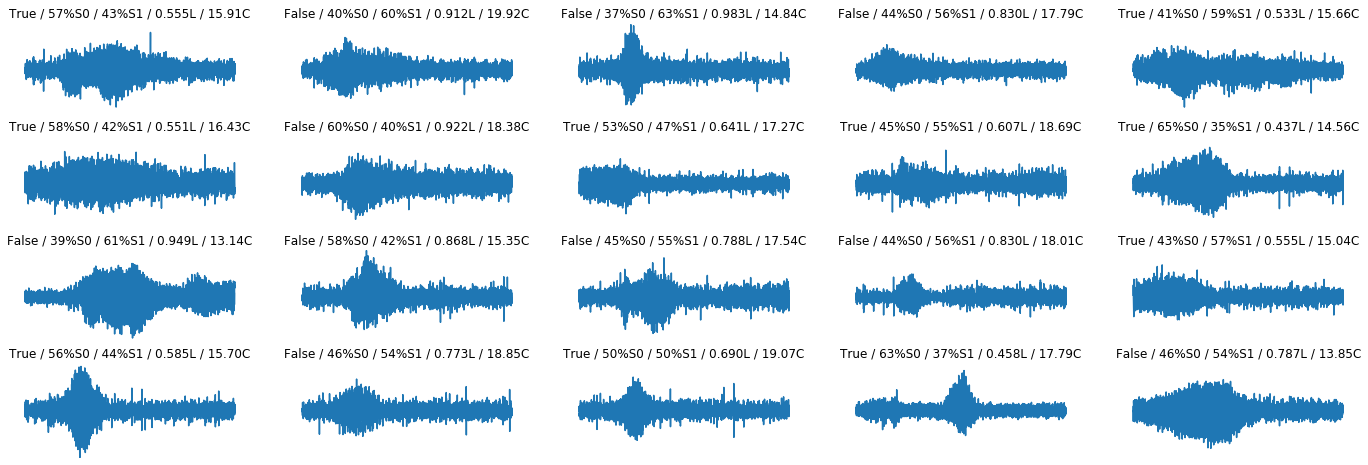

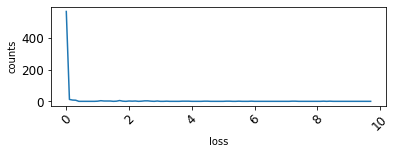

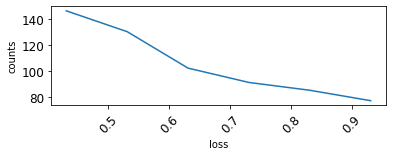

In [32]:
low = 0.35
high = 0.65

df_uncertain = df[(df.score0 > low) & (df.score0 < high) | (df.score1 > low) & (df.score1 < high)].reset_index().rename(columns={'index': 'index_og'})
print(f"{df_uncertain.shape[0]} within given range")

df_certain = df[~((df.score0 > low) & (df.score0 < high) | (df.score1 > low) & (df.score1 < high))].reset_index().rename(columns={'index': 'index_og'})

clnscore = get_clean_wingbeats_multiple_runs(names=df_uncertain.x.tolist())
df_uncertain['clean_score'] = clnscore
unc_idx_list = df_uncertain.index.to_series().sample(20, replace=False).tolist()

plt.figure(figsize=(24,8))
for i, idx in enumerate(unc_idx_list):
    plt.subplot(4,5,i+1)
    path = df_uncertain.x.loc[idx]
    label = df_uncertain.y.loc[idx]
    right = df_uncertain.right.loc[idx]
    clean_score = df_uncertain.clean_score.loc[idx]
    loss = df_uncertain.loss.loc[idx]
    score0 = df_uncertain.score0.loc[idx]
    score1 = df_uncertain.score1.loc[idx]
    sig = read_wbt(path)
    assert idx in unc_idx_list
    plt.plot(sig)
    plt.axis('off')
    plt.ylim(-.035,.035)
    plt.title(f"{right} / {score0:.0%}S0 / {score1:.0%}S1 / {loss:.3f}L / {clean_score:.2f}C")

# Print percentage of intermediates
correct = df_uncertain.right.sum() / df_uncertain.shape[0]
print(f"{correct:.2%}% correct for the uncertain data points ({df_uncertain.shape[0]} total), average loss: {df_uncertain.loss.mean():.4f}")
correct = df_certain.right.sum() / df_certain.shape[0]
print(f"{correct:.2%}% correct for certain data points ({df_certain.shape[0]} total), average loss: {df_certain.loss.mean():.4f}")
spl = df_certain.sample(650)
correct = spl.right.sum() / spl.shape[0]
print(f"{correct:.2%}% correct for a sample of certain data points ({spl.shape[0]} total), average loss: {spl.loss.mean():.4f}")
correct = df.right.sum() / df.shape[0]
print(f"{correct:.2%}% correct for all data points ({df.shape[0]} total), average loss: {df.loss.mean():.4f}")

plt.figure()
plt.subplot(2,1,1);np_hist(df_certain.sample(df_uncertain.shape[0]),'loss');
plt.subplot(2,1,2);np_hist(df_uncertain,'loss')

# Unkown Insect - Zaprionus

In [18]:
zaprionus = DatasetConfiguration(names=['LG'])
zaprionus.select(name='LG', species=['LG_zapr_26_09']); 
zaprionus.read();
print(f"Before cleaning: \n{zaprionus.df.labels.value_counts()}")
zaprionus.clean();
print(f"After cleaning: \n{zaprionus.df.labels.value_counts()}")

Dataset - LG - exists: True
Before cleaning: 
LG_zapr_26_09    7210
Name: labels, dtype: int64
After cleaning: 
LG_zapr_26_09    7022
Name: labels, dtype: int64


220/220 [==============================] - 5s 23ms/step


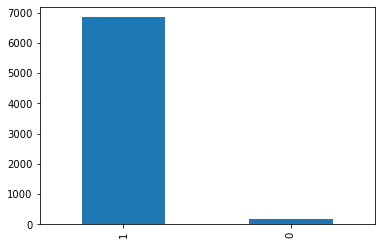

In [25]:
y_zapscores = model.predict(valid_generator(zaprionus.fnames.tolist(), [1 for i in zaprionus.fnames], # the label here doesn't matter since it basicaly extract the last layer features
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting, binary_labels=True),
                         steps=int(math.ceil(float(zaprionus.df.shape[0])/float(traincf.batch_size))),
                         verbose=1)
pd.Series(np.argmax(y_zapscores,axis=1)).value_counts().plot(kind='bar');

In [27]:
dfzap = pd.DataFrame({"x": zaprionus.fnames.tolist(), "y": [1 for i in zaprionus.fnames], "score0":y_zapscores[:,0], "score1":y_zapscores[:,1]})
dfzap['pred'] = np.argmax(y_zapscores, axis=1)
dfzap["right"] = False

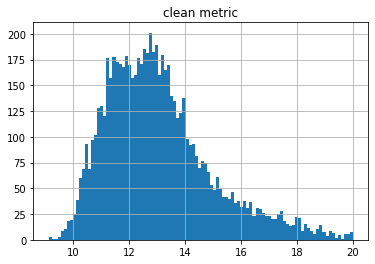

In [33]:
clnscore = get_clean_wingbeats_multiple_runs(names=dfzap.x.tolist())
dfzap['clean_score'] = clnscore
dfzap.clean_score.hist(bins=100);
plt.title("clean metric");

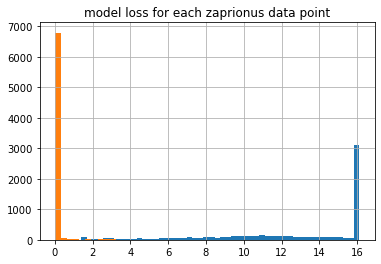

In [84]:
versions = [0,1]
for v in versions:
    y_zapcat = to_categorical([v for i in zaprionus.fnames])

    cce = CategoricalCrossentropy(reduction="none")

    loss = cce(K.variable(y_zapcat), K.variable(y_zapscores))
    dfzap[f'loss{v}'] = pd.Series(loss.numpy()).round(6)

    dfzap[f'loss{v}'].hist(bins=50);
    plt.title("model loss for each zaprionus data point");

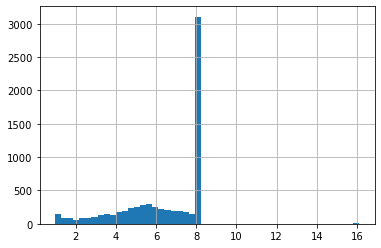

In [83]:
dfzap[['loss0','loss1']].mean(axis=1).hist(bins=50)

In [85]:
dfzap[dfzap[['loss0','loss1']].mean(axis=1)>2]

,x,y,score0,score1,pred,right,clean_score,loss0,loss1
0,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,3.044706e-13,1.000000,1,False,14.112984,16.118095,0.000000
1,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,2.920870e-20,1.000000,1,False,12.607521,16.118095,0.000000
2,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,1.075210e-11,1.000000,1,False,14.867266,16.118095,0.000000
3,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,2.969445e-07,1.000000,1,False,11.751258,15.029720,0.000000
4,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,2.528599e-23,1.000000,1,False,11.636634,16.118095,0.000000
...,...,...,...,...,...,...,...,...,...
7017,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,1.325673e-04,0.999867,1,False,10.864307,8.928553,0.000133
7018,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,2.179209e-21,1.000000,1,False,12.301978,16.118095,0.000000
7019,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,4.773710e-11,1.000000,1,False,17.094403,16.118095,0.000000
7020,/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_0...,1,5.233559e-06,0.999995,1,False,14.275101,12.160425,0.000005


# Unkown Insect - MeBioS suzukii

In [86]:
suzukii = DatasetConfiguration(names=['Suzukii_RL'])
suzukii.select(name='Suzukii_RL', species=['R']); 
suzukii.read();
print(f"Before cleaning: \n{suzukii.df.labels.value_counts()}")
suzukii.clean();
print(f"After cleaning: \n{suzukii.df.labels.value_counts()}")

Dataset - Suzukii_RL - exists: True
Before cleaning: 
R    14348
Name: labels, dtype: int64
After cleaning: 
R    10140
Name: labels, dtype: int64


317/317 [==============================] - 7s 22ms/step


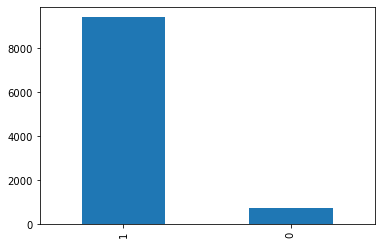

In [87]:
y_suzscores = model.predict(valid_generator(suzukii.fnames.tolist(), [1 for i in suzukii.fnames], # the label here doesn't matter since it basicaly extract the last layer features
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting, binary_labels=True),
                         steps=int(math.ceil(float(suzukii.df.shape[0])/float(traincf.batch_size))),
                         verbose=1)
pd.Series(np.argmax(y_suzscores,axis=1)).value_counts().plot(kind='bar');

In [89]:
dfsuz = pd.DataFrame({"x": suzukii.fnames.tolist(), "y": [1 for i in suzukii.fnames], "score0":y_suzscores[:,0], "score1":y_suzscores[:,1]})
dfsuz['pred'] = np.argmax(y_suzscores, axis=1)
dfsuz["right"] = False

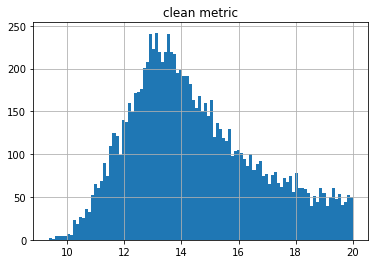

In [90]:
clnscore = get_clean_wingbeats_multiple_runs(names=dfsuz.x.tolist())
dfsuz['clean_score'] = clnscore
dfsuz.clean_score.hist(bins=100);
plt.title("clean metric");

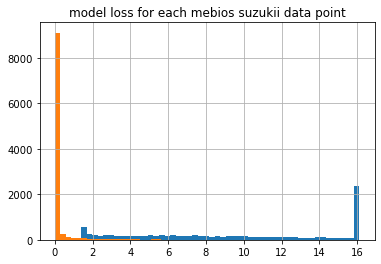

In [91]:
versions = [0,1]
for v in versions:
    y_suzcat = to_categorical([v for i in suzukii.fnames])

    cce = CategoricalCrossentropy(reduction="none")

    loss = cce(K.variable(y_suzcat), K.variable(y_suzscores))
    dfsuz[f'loss{v}'] = pd.Series(loss.numpy()).round(6)

    dfsuz[f'loss{v}'].hist(bins=50);
    plt.title("model loss for each mebios suzukii data point");

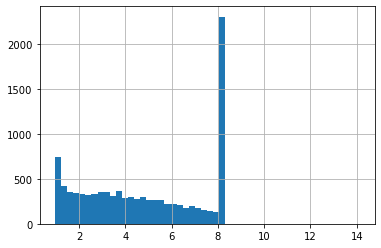

In [92]:
dfsuz[['loss0','loss1']].mean(axis=1).hist(bins=50)

In [93]:
dfsuz[dfsuz[['loss0','loss1']].mean(axis=1)>2]

,x,y,score0,score1,pred,right,clean_score,loss0,loss1
0,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,4.126457e-03,0.995874,1,False,17.169162,5.494471,0.004135
1,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,5.787818e-04,0.999421,1,False,18.229857,7.455164,0.000579
2,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,2.064502e-04,0.999794,1,False,16.522449,8.485657,0.000206
3,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,2.405595e-13,1.000000,1,False,12.910261,16.118095,0.000000
4,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,5.386532e-04,0.999461,1,False,14.473140,7.526978,0.000539
...,...,...,...,...,...,...,...,...,...
10135,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,1.925706e-03,0.998074,1,False,12.878632,6.254390,0.001928
10136,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,8.487764e-07,0.999999,1,False,14.031738,13.979471,0.000001
10137,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,9.776389e-01,0.022361,0,False,15.093343,3.823046,3.800431
10138,/home/kalfasyan/data/wingbeats/Suzukii_RL/R/D_...,1,7.504321e-06,0.999992,1,False,14.058974,11.800039,0.000008


### Setting a threshold for unknowns

In [69]:
th_df =  df[df.loss < 4]
th_y_test = th_df.y
th_y_pred = th_df.pred
print(f"{len(df) - len(th_y_test)} points discarded")
balanced_accuracy_score(y_pred=th_y_pred, y_true=th_y_test)

561 points discarded


0.946328419660577

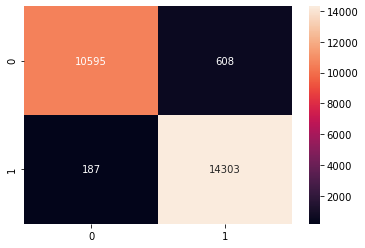

In [43]:
import seaborn as sns
cm = confusion_matrix(y_pred=th_y_pred, y_true=th_y_test)
sns.heatmap(cm, annot=True, fmt='g')

In [49]:
len(y_scores)

26763

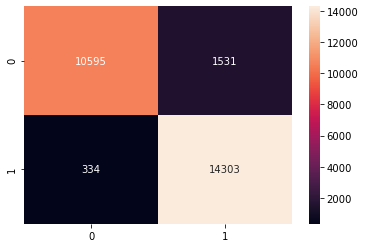

In [50]:
import seaborn as sns
cm = confusion_matrix(y_pred=np.argmax(y_scores,axis=1), y_true=y_test)
sns.heatmap(cm, annot=True, fmt='g')

In [93]:
th_df.right.value_counts()

True     24898
False      795
Name: right, dtype: int64